# Understanding School Performance on Pennsylvania Standardized Tests

## Preprocessing and Baseline Modeling

The objective of this notebook is to build a baseline model and generate metrics to use as a reference point to build on for extended modeling. To do so, we will finalize our design matrix and target vectors, and split them into training and testing datasets.  For our baseline model, we will be using sklearn's Linear Regression algorithm.

Additionally, we will also assess the pairwise collinearity of the features in our design matrix, and create a list of features to potentially drop in the next notebook on extended modeling.  Along the way, we will also scale our features by standardization.

Upon analyzing the results of our baseline models and the evaluation metrics, we will create a plan at the end of this notebook for extended modeling to be completed in the next notebook.

### Contents:

1. [Import packages and load data](#section1)
2. [Assess pairwise collinearity](#section2)
3. [Train test split](#section3)
4. [Feature scaling](#section4)
5. [Baseline modeling](#section5)
6. [Plan for extended modeling](#section6)


<a id='section1'></a>
## 1. Import packages and load data

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
# load cleaned data from csv file
df = pd.read_csv('../Data/school_data_1819_2.csv', index_col = 0)

In [3]:
# check columns
df.columns

Index(['SchoolName', 'SchoolNumber', 'School Zip Code', 'DistrictName', 'AUN',
       'Title I School', 'Title I (Binary)', 'School Enrollment',
       'Male (School)', 'Female (School)',
       'Percent Regular Attendance (All Student)',
       'American Indian/Alaskan Native', 'Asian', 'Black/African American',
       'Hispanic', 'Native Hawaiian or other Pacific Islander', 'White',
       '2 or More Races', 'English Learner', 'Special Education',
       'Percent of Gifted Students', 'Economically Disadvantaged',
       'Foster Care', 'Homeless', 'Military Connected',
       'Local - Non-Personnel', 'Local - Personnel', 'Total Local Expenditure',
       'State - Non-Personnel', 'State - Personnel', 'Total State Expenditure',
       'Federal - Non-Personnel', 'Federal - Personnel',
       'Total Federal Expenditure', 'Total Non-Personnel Expenditure',
       'Total Personnel Expenditure', 'Total Expenditure',
       'Percent Proficient or Advanced ELA/Literature (All Student)',
      

In [4]:
# establish design matrix, call it 'predictors'
predictors = df.drop(['SchoolName', \
                      'SchoolNumber', \
                      'School Zip Code', \
                      'DistrictName', \
                      'AUN', \
                      'Title I School', \
                      'Percent Proficient or Advanced ELA/Literature (All Student)', \
                      'Percent Proficient or Advanced Mathematics/Algebra 1 (All Student)'], \
                     axis = 1) 

# target vectors
target_ELA = df['Percent Proficient or Advanced ELA/Literature (All Student)']
target_math = df['Percent Proficient or Advanced Mathematics/Algebra 1 (All Student)']

In [5]:
#check datatypes of predictors
predictors.dtypes

Title I (Binary)                               int64
School Enrollment                              int64
Male (School)                                float64
Female (School)                              float64
Percent Regular Attendance (All Student)     float64
American Indian/Alaskan Native               float64
Asian                                        float64
Black/African American                       float64
Hispanic                                     float64
Native Hawaiian or other Pacific Islander    float64
White                                        float64
2 or More Races                              float64
English Learner                              float64
Special Education                            float64
Percent of Gifted Students                   float64
Economically Disadvantaged                   float64
Foster Care                                  float64
Homeless                                     float64
Military Connected                           f

All of of our features are numeric, and we have no categorical variables that need to be converted to dummy variables.

<a id='section2'></a>
## 2. Assess pairwise collinearity

As we observed in the previous notebook, there are quite a few of our independent variables that are correlated with another.  With that in mind, there is concern that this may lead to overfitting and an increase in the error of our model. 

By looking at the pairwise collinearity of our variables, we can identify and place feature pairs in one of three buckets based on the correlation coefficients:

- $|r|$ is <b>0.5 or below:</b> low correlation
- $|r|$ is between <b>0.5 and 0.7:</b> mid correlation
- $|r|$ is <b>0.7 and above:</b> high correlation

We will look at the mid correlation and high correlation buckets and determine any features that may potentially be deleted and generate a list.

In our next notebook (extended modeling), we will train, test, and compare models with all features included vs highly correlated features removed.  We will also explore models such as ridge regression and LASSO regression that can introduce penalization on information that is redundant.

In [6]:
# Construct correlation matrix and take the absolute value of all correlation coefficients
corr_abs = predictors.corr().abs()

# Select upper triangle of correlation matrix
upper_corr_abs = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

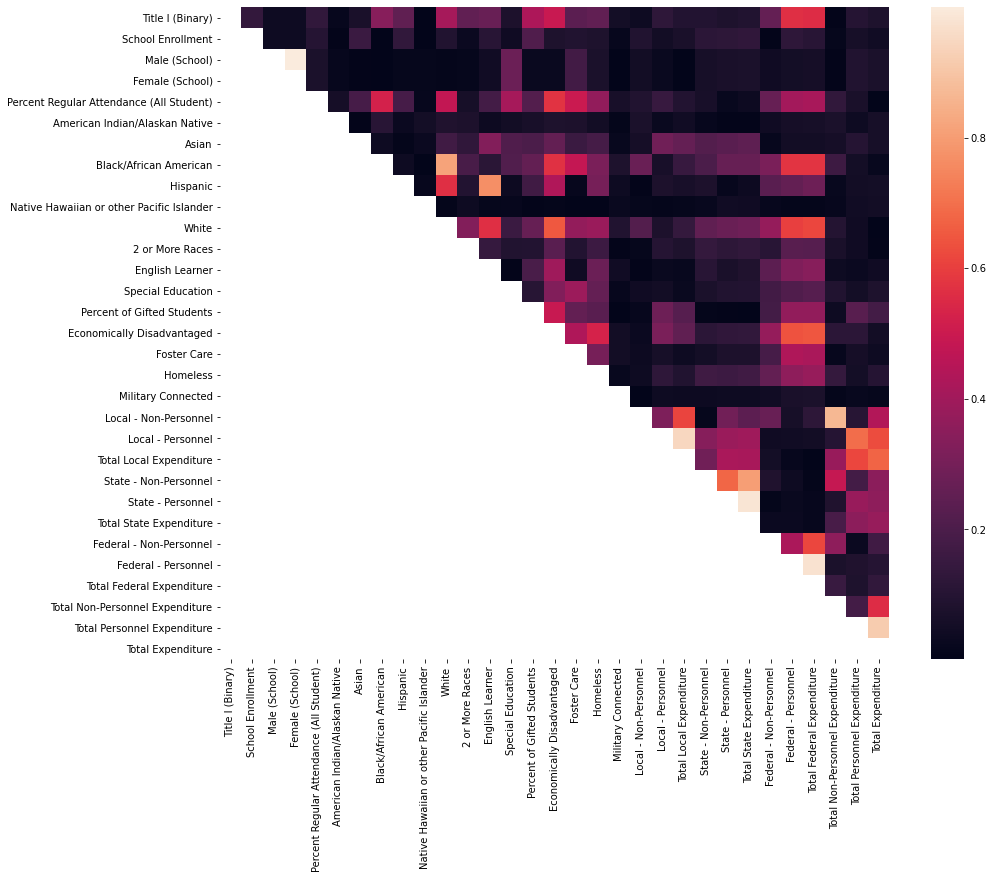

In [7]:
# plot the correlation heatmap
plt.subplots(figsize=(15,12))
sns.heatmap(upper_corr_abs)
plt.show()

Looking at this heatmap of pairwise correlation, there definitely exist predictor variables that are highly correlated with another. 

We'll create three functions that will take this correlation matrix and identify which pairs of features are highly correlated, somewhat correlated, and not very correlated.

In [8]:
def high_corr(correlation_matrix, high_threshold):
    """creates a list of feature pairs as tuples that are highly correlated"""
    
    high_corr_list = []
    
    for i in range(len(correlation_matrix)):
    #iterate through 'i' rows
    
        for j in range(len(correlation_matrix)):
        #iterate through 'j' columns
            if correlation_matrix.iloc[i][j] > high_threshold:
                high_corr_list.append((correlation_matrix.index[i], correlation_matrix.columns[j], round(correlation_matrix.iloc[i][j], 4)))
    
    return high_corr_list


def mid_corr(correlation_matrix, mid_threshold, high_threshold):
    """creates a list of feature pairs as tuples that are somewhat correlated"""
    
    mid_corr_list = []
    
    for i in range(len(correlation_matrix)):
    #iterate through 'i' rows
    
        for j in range(len(correlation_matrix)):
        #iterate through 'j' columns
            if correlation_matrix.iloc[i][j] > mid_threshold and correlation_matrix.iloc[i][j] <= high_threshold:
                mid_corr_list.append((correlation_matrix.index[i], correlation_matrix.columns[j], round(correlation_matrix.iloc[i][j], 4)))
    
    return mid_corr_list


def low_corr(correlation_matrix, mid_threshold):
    """creates a list of feature pairs as tuples that have low correlation"""
    
    low_corr_list = []
    
    for i in range(len(correlation_matrix)):
    #iterate through 'i' rows
    
        for j in range(len(correlation_matrix)):
        #iterate through 'j' columns
            if correlation_matrix.iloc[i][j] <= mid_threshold:
                low_corr_list.append((correlation_matrix.index[i], correlation_matrix.columns[j], round(correlation_matrix.iloc[i][j], 4)))
    
    return low_corr_list

Now that we have the functions defined, we'll examine the pairwise collinearity of our dataset.

In [9]:
# create list of feature pairs with |r|<0.5
low_corr_pairs = low_corr(upper_corr_abs, 0.5)
low_corr_pairs

[('Title I (Binary)', 'School Enrollment', 0.1363),
 ('Title I (Binary)', 'Male (School)', 0.0385),
 ('Title I (Binary)', 'Female (School)', 0.0385),
 ('Title I (Binary)', 'Percent Regular Attendance (All Student)', 0.1328),
 ('Title I (Binary)', 'American Indian/Alaskan Native', 0.019),
 ('Title I (Binary)', 'Asian', 0.0689),
 ('Title I (Binary)', 'Black/African American', 0.3422),
 ('Title I (Binary)', 'Hispanic', 0.2471),
 ('Title I (Binary)', 'Native Hawaiian or other Pacific Islander', 0.0026),
 ('Title I (Binary)', 'White', 0.4123),
 ('Title I (Binary)', '2 or More Races', 0.2533),
 ('Title I (Binary)', 'English Learner', 0.2693),
 ('Title I (Binary)', 'Special Education', 0.0792),
 ('Title I (Binary)', 'Percent of Gifted Students', 0.43),
 ('Title I (Binary)', 'Economically Disadvantaged', 0.4959),
 ('Title I (Binary)', 'Foster Care', 0.2375),
 ('Title I (Binary)', 'Homeless', 0.2545),
 ('Title I (Binary)', 'Military Connected', 0.055),
 ('Title I (Binary)', 'Local - Non-Personn

In [10]:
# create list of feature pairs with 0.5<|r|<0.7
mid_corr_pairs = mid_corr(upper_corr_abs, 0.5, 0.7)
mid_corr_pairs

[('Title I (Binary)', 'Federal - Personnel', 0.564),
 ('Title I (Binary)', 'Total Federal Expenditure', 0.5554),
 ('Percent Regular Attendance (All Student)',
  'Black/African American',
  0.5249),
 ('Percent Regular Attendance (All Student)',
  'Economically Disadvantaged',
  0.5739),
 ('Black/African American', 'Economically Disadvantaged', 0.5677),
 ('Black/African American', 'Federal - Personnel', 0.5756),
 ('Black/African American', 'Total Federal Expenditure', 0.5777),
 ('Hispanic', 'White', 0.5649),
 ('White', 'English Learner', 0.566),
 ('White', 'Economically Disadvantaged', 0.6524),
 ('White', 'Federal - Personnel', 0.6012),
 ('White', 'Total Federal Expenditure', 0.6155),
 ('Economically Disadvantaged', 'Homeless', 0.5312),
 ('Economically Disadvantaged', 'Federal - Personnel', 0.6379),
 ('Economically Disadvantaged', 'Total Federal Expenditure', 0.6472),
 ('Local - Non-Personnel', 'Total Local Expenditure', 0.6102),
 ('Local - Personnel', 'Total Personnel Expenditure', 0.69

In [11]:
# create list of feature pairs with |r|>0.7
high_corr_pairs = high_corr(upper_corr_abs, 0.7)
high_corr_pairs

[('Male (School)', 'Female (School)', 1.0),
 ('Black/African American', 'White', 0.8143),
 ('Hispanic', 'English Learner', 0.7677),
 ('Local - Non-Personnel', 'Total Non-Personnel Expenditure', 0.8637),
 ('Local - Personnel', 'Total Local Expenditure', 0.9461),
 ('State - Non-Personnel', 'Total State Expenditure', 0.8016),
 ('State - Personnel', 'Total State Expenditure', 0.9832),
 ('Federal - Personnel', 'Total Federal Expenditure', 0.9747),
 ('Total Personnel Expenditure', 'Total Expenditure', 0.9164)]

As expected, we have a few feature pairs that are highly correlated.  Certainly the percentage of male students and percentage of female students will have a correlation coefficient that is close to, if not equal to -1.  We're also seeing that the percentage of black students and percentage of white students are also strongly correlated. 

Most of the high correlation feature pairs are a result of the various 'Total' expenditure columns that we created during EDA.  

Among the <b>second</b> element of the high correlation pairs, the only total that seems to be missing is 'Total Personnel Expenditure'.  We notice that when we look at the mid-correlation pairs, that 'Local - Personnel' and 'Total Personnel Expenditure' have a correlation coefficient of 0.694.  

If we are removing our engineered 'Total' expenditure features, it may make sense to remove all of them.  As a result, we will run our function again, but with a threshold of 0.69.

In [12]:
high_corr_pairs_2 = high_corr(upper_corr_abs, 0.69)
high_corr_pairs_2

[('Male (School)', 'Female (School)', 1.0),
 ('Black/African American', 'White', 0.8143),
 ('Hispanic', 'English Learner', 0.7677),
 ('Local - Non-Personnel', 'Total Non-Personnel Expenditure', 0.8637),
 ('Local - Personnel', 'Total Local Expenditure', 0.9461),
 ('Local - Personnel', 'Total Personnel Expenditure', 0.694),
 ('State - Non-Personnel', 'Total State Expenditure', 0.8016),
 ('State - Personnel', 'Total State Expenditure', 0.9832),
 ('Federal - Personnel', 'Total Federal Expenditure', 0.9747),
 ('Total Personnel Expenditure', 'Total Expenditure', 0.9164)]

We'll create a list of features to potentially delete.  To do so, we'll select the second feature from each tuple pair.

Then, we'll create a new design matrix without these features.

In [13]:
# create an empty list of features to potentially delete
corr_features = []

# iterate through our high_corr_pairs list and add the second item of each tuple to our corr_features list
for tup in high_corr_pairs_2:
    corr_features.append(tup[1])

In [14]:
# use the 'set' data structure to elimnate any duplicates
corr_features = list(set(corr_features))
corr_features

['Female (School)',
 'Total Federal Expenditure',
 'English Learner',
 'White',
 'Total Personnel Expenditure',
 'Total State Expenditure',
 'Total Expenditure',
 'Total Non-Personnel Expenditure',
 'Total Local Expenditure']

We'll save this list for our next notebook on extended modeling.

In [15]:
import pickle

# save list in Data directory as corr_features.pkl
with open('../Data/corr_features.pkl', 'wb') as f:
    pickle.dump(corr_features, f)

<a id='section3'></a>
## 3. Train Test Split

We'll split our dataset into an 80/20 train/test split ratio.  For the sake of simplicity, we want our design X_train and X_test to be identical for both ELA and Math models.  To achieve this, we'll split our ELA target variable, and then filter our math target variable using the respective indices for the train and test sets.

In [16]:
#Check partition sizes with 80/20 train/test split
print(len(predictors) * .8, len(predictors) * .2)

2138.4 534.6


In [17]:
# create train test split with original predictors and ELA as the target variable
X_train, X_test, y_train_ELA, y_test_ELA = train_test_split(predictors, 
                                                            target_ELA, 
                                                            test_size=0.2, 
                                                            random_state=16)

Now that we've split our train and test sets, we'll use the indices of X_train and X_test to filter and split our math target variable.

In [18]:
train_indices = X_train.index
test_indices = X_test.index

In [19]:
y_train_math = target_math.filter(items = train_indices, axis = 0)
y_test_math = target_math.filter(items = test_indices, axis = 0)

In [20]:
#check partition size of design matrix
X_train.shape, X_test.shape

((2138, 31), (535, 31))

In [21]:
#check partition size for ELA
y_train_ELA.shape, y_test_ELA.shape

((2138,), (535,))

In [22]:
#check partition size for math
y_train_math.shape, y_test_math.shape

((2138,), (535,))

<a id='section4'></a>
## 4. Feature Scaling

We will apply a standard scaler since some of our variables do not have a defined maximum value (namely our expenditure variables).

To prevent potentially leaking information from our test set into the model, we will fit the scaler on only the training data and then standardize both the training and test sets with this scaler.

In [23]:
# instantiate standard scaler
sc = StandardScaler()

# fit the scaler on the training set and transform it
X_train_sc = sc.fit_transform(X_train)

# transform the test set
X_test_sc = sc.transform(X_test)

We'll also convert our target vectors into numpy arrays here.

In [24]:
y_train_ELA = y_train_ELA.to_numpy().ravel()
y_test_ELA = y_test_ELA.to_numpy().ravel()

y_train_math = y_train_math.to_numpy().ravel()
y_test_math = y_test_math.to_numpy().ravel()

<a id='section5'></a>
## 5. Baseline Modeling

For our initial baseline models, we will be using Linear Regression.

We'll define a function that will graph our residual plot and distribution of residuals

In [25]:
def graph_residuals(Subject, Features, Algorithm, y_train, y_train_pred, y_test, y_test_pred):
    """Function that will graph residual plot and distribution of residuals"""
    residual_train = y_train - y_train_pred
    residual_test = y_test - y_test_pred
    
    r2_train = str(round(r2_score(y_train, y_train_pred), 4))
    r2_test = str(round(r2_score(y_test, y_test_pred), 4))
    
    train_var = str(round(np.var(residual_train), 2))
    test_var = str(round(np.var(residual_test), 2))
    
    print('Graphs for')
    print('Target:', Subject, 'Performance')
    print('Features:', Features)
    print('Algorithm:', Algorithm)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
    
    ax1.scatter(y_train, y_train_pred, alpha = 0.6, color = 'steelblue', label = 'Train')
    ax1.scatter(y_test, y_test_pred, alpha = 0.6, color = 'yellowgreen', label = 'Test')
    ax1.plot([x for x in range(0, 100)],[x for x in range(0, 100)], color='black')
    ax1.set_title('Actual vs. Predicted')
    ax1.set_ylabel('Predicted Values')
    ax1.set_xlabel('Actual Values')
    ax1.legend(loc='upper left')
    
    ax2.scatter(y_train_pred, residual_train, alpha = 0.6, color = 'steelblue',
                label = 'Train ' + "$" + 'R^2' + "$" + ' = ' + r2_train)
    ax2.scatter(y_test_pred, residual_test, alpha = 0.6, color = 'yellowgreen',
                label = 'Test ' + "$" + 'R^2' + "$" + ' = ' + r2_test)
    ax2.axhline(y=0, color = 'black')
    ax2.set_title('Residual Plot')
    ax2.set_ylabel('Residuals')
    ax2.set_xlabel('Predicted Values')
    ax2.legend(loc='upper left')

    ax3.hist(residual_train,  bins = 30, color = 'steelblue', label = 'Train Variance = ' + train_var)
    ax3.hist(residual_test, bins = 30, alpha = 0.8, color = 'yellowgreen', label = 'Test Variance = ' + test_var)
    ax3.axvline(x=0, color = 'black')
    ax3.set_title('Distribution of Residuals')
    ax3.set_xlabel('Residuals')
    ax3.set_ylabel('Count')
    ax3.legend(loc='upper left')

    plt.show()

We will also set up a table to compare metrics and define a function that will add the metrics of each model to this table.

In [26]:
# set up column names for metrics table
column_names = ["Subject", 
                "Features",
                "Algorithm", 
                "Train r2", 
                "Train MAE", 
                'Train 95% Worst Case Error LB',
                'Train 95% Worst Case Error UB',
                "Test r2", 
                "Test MAE", 
                'Test 95% Worst Case Error LB',
                'Test 95% Worst Case Error UB'
               ]

# create dataframe for metrics table with column names listed above
metrics = pd.DataFrame(columns = column_names)

In [27]:
def add_metrics(Subject, Features, Algorithm, y_train, y_train_pred, y_test, y_test_pred):

    new_row = {'Subject':Subject,
               'Features':Features,
               'Algorithm':Algorithm,
               'Train r2': r2_score(y_train, y_train_pred),
               'Train MAE': mean_absolute_error(y_train, y_train_pred),
               'Train 95% Worst Case Error LB': np.percentile(y_train - y_train_pred, 2.5),
               'Train 95% Worst Case Error UB': np.percentile(y_train - y_train_pred, 97.5),
               'Test r2': r2_score(y_test, y_test_pred),
               'Test MAE': mean_absolute_error(y_test, y_test_pred),
               'Test 95% Worst Case Error LB': np.percentile(y_test - y_test_pred, 2.5),
               'Test 95% Worst Case Error UB': np.percentile(y_test - y_test_pred, 97.5)
              }
    
    global metrics
    
    metrics = metrics.append(new_row, ignore_index = True)

As a quick side note, I had originally intended to use the Mean Absolute Percentage Error as another metric.  However, upon realizing that some of our actual target values are equal to 0, this produced a division by 0 error in the calculation.  As a result, we will not be using this metric.

### 5a. Target = ELA performance

In [28]:
# instantiate LinearRegression for ELA
lr_ELA = LinearRegression()

#fit on training data for ELA
lr_ELA.fit(X_train_sc, y_train_ELA)

# predict on train set and test set
y_train_ELA_pred = lr_ELA.predict(X_train_sc)
y_test_ELA_pred = lr_ELA.predict(X_test_sc)

Graphs for
Target: ELA Performance
Features: All features
Algorithm: Linear Regression (baseline)


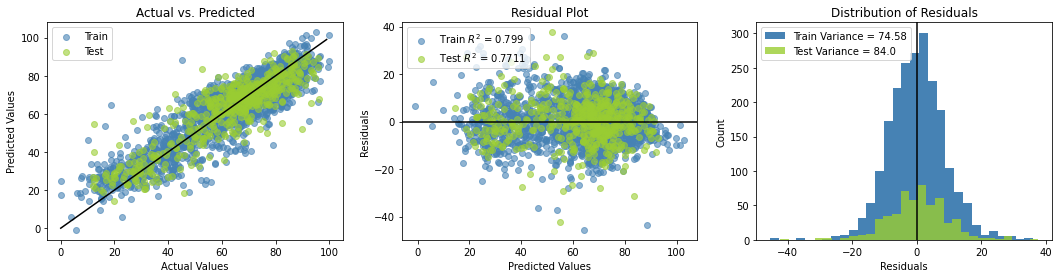

In [29]:
graph_residuals('ELA', 
                'All features', 
                'Linear Regression (baseline)', 
                y_train_ELA, 
                y_train_ELA_pred, 
                y_test_ELA, 
                y_test_ELA_pred
               )

In [30]:
add_metrics('ELA', 
                'All features', 
                'Linear Regression (baseline)', 
                y_train_ELA, 
                y_train_ELA_pred, 
                y_test_ELA, 
                y_test_ELA_pred
               )

### 5b. Target = math performance

In [31]:
# instantiate LinearRegression for math
lr_math = LinearRegression()

#fit on training data for ELA
lr_math.fit(X_train_sc, y_train_math)

# predict on train set and test set
y_train_math_pred = lr_math.predict(X_train_sc)
y_test_math_pred = lr_math.predict(X_test_sc)

Graphs for
Target: Math Performance
Features: All features
Algorithm: Linear Regression (baseline)


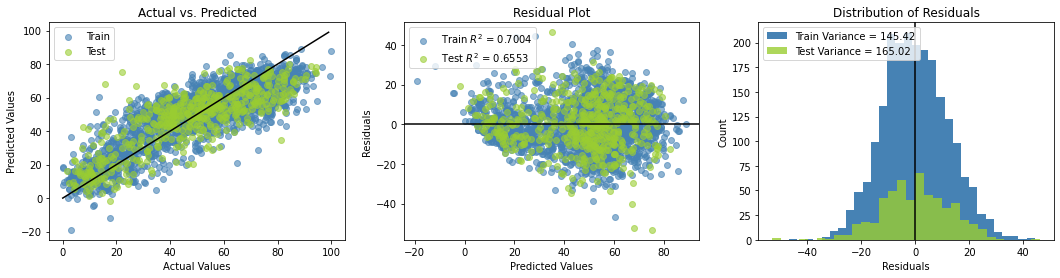

In [32]:
graph_residuals('Math', 
                'All features', 
                'Linear Regression (baseline)', 
                y_train_math, 
                y_train_math_pred, 
                y_test_math, 
                y_test_math_pred
               )

In [33]:
add_metrics('Math', 
                'All features', 
                'Linear Regression (baseline)', 
                y_train_math, 
                y_train_math_pred, 
                y_test_math, 
                y_test_math_pred
               )

In [34]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108


Our model for ELA seems to have satisfactory performance, with a test $r^2$ score of 0.77 and mean absolute error equal to 6.95.

Our model for math does not perform as well, with a test $r^2$ score of 0.65 and mean absolute error equal to 10.12. The distribution of residuals are also more spread out for math than for ELA.

Generally speaking, our models for ELA and Math do not seem to be overfitting, which is a good sign.

<a id='section6'></a>
## 6. Plan for extended modeling

Our objective for extended modeling will be to improve the performance of our models with respect to $r^2$ score, MAE, and RMSE.  In particular, we would like to see our performance on models for Percent Proficient or Advanced in Math improve.  

The solution space for extended modeling for each of our two models (ELA performance and Math performance) is as follows:
- 2 different design matrices, one with all features retained, the other with highly correlated features removed
- 3 regression algorithms:
    - Random Forest
    - LGBM
    - XGBoost


This will give us 6 models to compare for each of our two target variables.  We will also apply hyperparameter tuning methods to each of our models along the way.

For our ELA models, we would ideally like to see a test $r^2$ score of at least 0.8 and a mean absolute error that is less than or equal to 6 percentage points.  For our math models, we would ideally like to see a test $r^2$ score of at least 0.7 and a mean absolute error that is less than or equal to 9 percentage points. 

We will also use the distribution of residual plots to help determine model selection.

In [35]:
# save train test split data
X_train.to_csv('../Data/X_train.csv')
X_test.to_csv('../Data/X_test.csv')

pd.DataFrame(X_train_sc, columns = X_train.columns).to_csv('../Data/X_train_scaled.csv')
pd.DataFrame(X_test_sc, columns = X_test.columns).to_csv('../Data/X_test_scaled.csv')

pd.DataFrame(y_train_ELA, columns = ['Percent Proficient in ELA']).to_csv('../Data/y_train_ELA.csv')
pd.DataFrame(y_test_ELA, columns = ['Percent Proficient in ELA']).to_csv('../Data/y_test_ELA.csv')

pd.DataFrame(y_train_math, columns = ['Percent Proficient in Math']).to_csv('../Data/y_train_math.csv')
pd.DataFrame(y_test_math, columns = ['Percent Proficient in Math']).to_csv('../Data/y_test_math.csv')

#save metrics dataframe
metrics.to_csv('../Data/metrics.csv')